In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 percent More hold LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


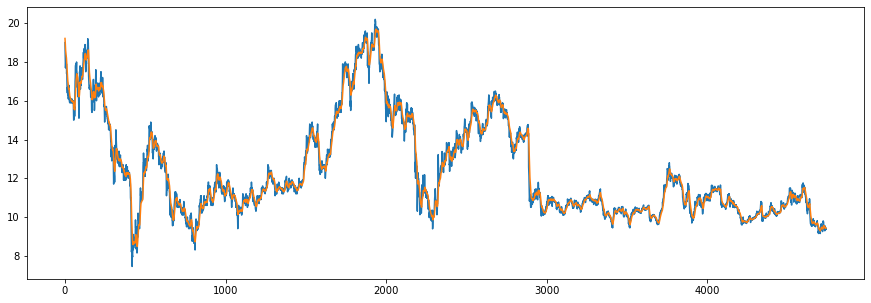

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


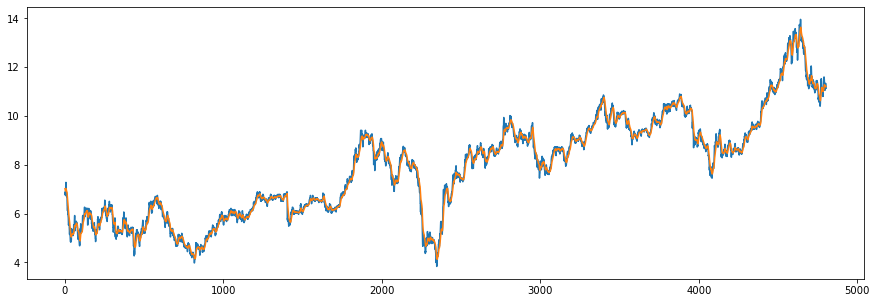

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


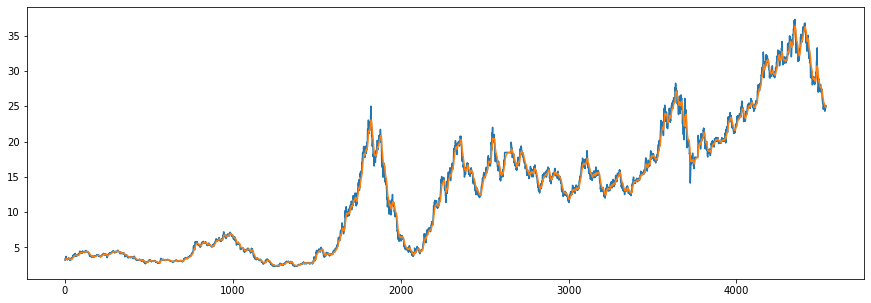

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


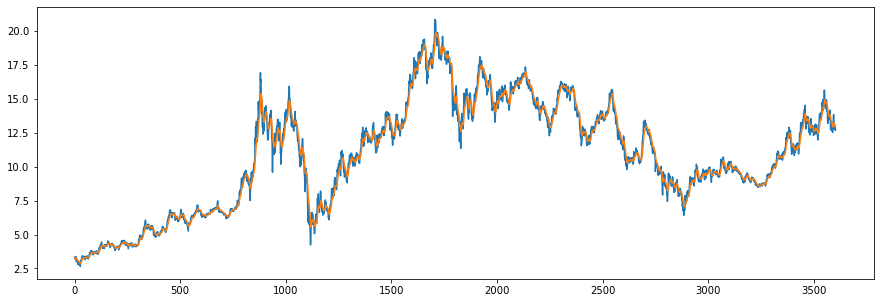

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


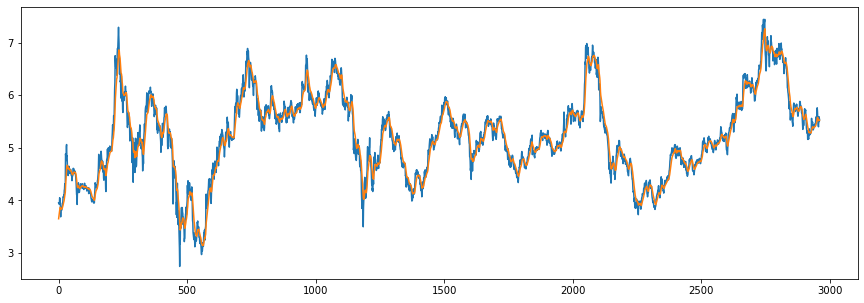

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


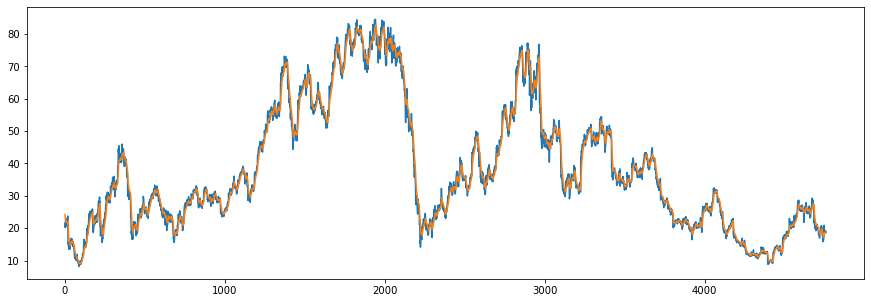

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


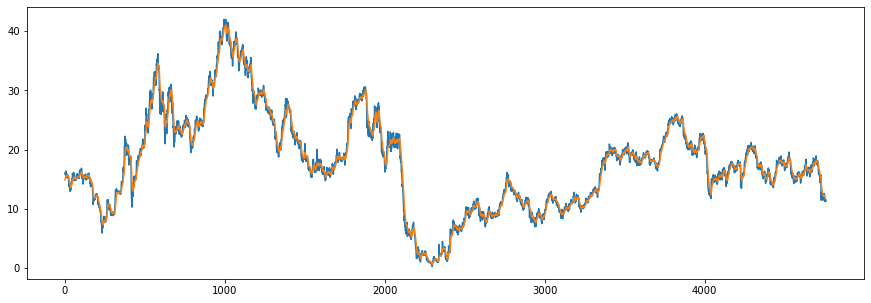

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


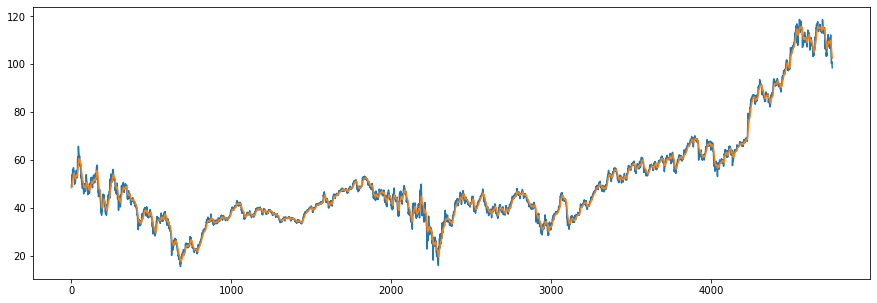

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


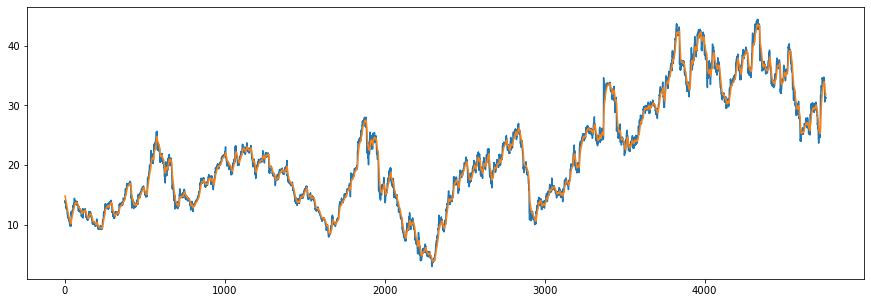

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


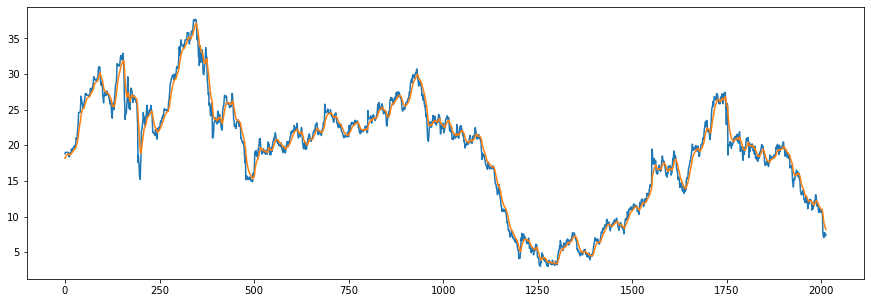

In [10]:
labels = []
sequential = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(41550, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(41550,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1384]
class_1 = class_1[0:1384]
class_2 = class_2[0:1845]

class_0_labels = class_0_labels[0:1384]
class_1_labels = class_1_labels[0:1384]
class_2_labels = class_2_labels[0:1845]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(4613, 15, 4)


Counter({0.0: 1384, 1.0: 1384, 2.0: 1845})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.3670 - accuracy: 0.2734 - mse: 0.4416 - weighted_accuracy: 0.2392 - weighted_mse: 0.4588WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 39ms/step - loss: 0.2727 - accuracy: 0.3764 - mse: 0.5478 - weighted_accuracy: 0.3630 - weighted_mse: 0.5534 - val_loss: 0.2975 - val_accuracy: 0.2925 - val_mse: 0.3516 - val_weighted_accuracy: 0.2925 - val_weighted_mse: 0.3516
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1956 - accuracy: 0.4705 - mse: 0.8798 - weighted_accuracy: 0.4924 - weighted_mse: 0.8760 - val_loss: 0.2864 - val_accuracy: 0.3001 - val_mse: 0.3768 - val_weighted_accuracy: 0.3

7/7 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.4093 - mse: 1.4408 - weighted_accuracy: 0.4093 - weighted_mse: 1.4408
Test loss: 0.1732897013425827
Test accuracy: 0.40930232405662537


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 88
actual holds but predicted sell: 32
actual predicted holds: 78
Percentage buys correct: 6.25%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 93.97590361445783%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 41.666666666666664%
Percentage high sells correct: 52.77777777777778%
Percentage mid holds correct: 87.8048780487805%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from p

7/7 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.3907 - mse: 1.3836 - weighted_accuracy: 0.3907 - weighted_mse: 1.3836
Test loss: 0.17856654524803162
Test accuracy: 0.3906976878643036


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 77
actual holds but predicted sell: 45
actual predicted holds: 71
Percentage buys correct: 10.465116279069768%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 88.75%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 55.10204081632653%
Percentage mid holds correct: 82.27848101265823%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.1770 - accuracy: 0.4178 - mse: 1.4446 - weighted_accuracy: 0.4178 - weighted_mse: 1.4446
Test loss: 0.17702102661132812
Test accuracy: 0.4178403615951538


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 85
actual holds but predicted sell: 30
actual predicted holds: 78
Percentage buys correct: 8.421052631578947%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.76470588235294%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.31578947368421%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.4886 - mse: 1.3372 - weighted_accuracy: 0.4886 - weighted_mse: 1.3372
Test loss: 0.16624504327774048
Test accuracy: 0.4885844886302948


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 61
actual holds but predicted sell: 39
actual predicted holds: 97
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 89.81481481481481%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.25373134328358%
Percentage high sells correct: 60.46511627906977%
Percentage mid holds correct: 84.25925925925925%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.5068 - mse: 1.3332 - weighted_accuracy: 0.5068 - weighted_mse: 1.3332
Test loss: 0.16478516161441803
Test accuracy: 0.5068492889404297


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 61
actual holds but predicted sell: 36
actual predicted holds: 100
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 91.74311926605505%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 65.0%
Percentage mid holds correct: 86.23853211009174%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bought: -80.

Epoch 11/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1382 - accuracy: 0.6623 - mse: 1.7160 - weighted_accuracy: 0.6874 - weighted_mse: 1.7118 - val_loss: 0.1603 - val_accuracy: 0.6046 - val_mse: 1.6521 - val_weighted_accuracy: 0.6046 - val_weighted_mse: 1.6521
Epoch 12/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1371 - accuracy: 0.6656 - mse: 1.7286 - weighted_accuracy: 0.6906 - weighted_mse: 1.7242 - val_loss: 0.1595 - val_accuracy: 0.6035 - val_mse: 1.7850 - val_weighted_accuracy: 0.6035 - val_weighted_mse: 1.7850
Epoch 13/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1375 - accuracy: 0.6615 - mse: 1.7363 - weighted_accuracy: 0.6875 - weighted_mse: 1.7310 - val_loss: 0.1635 - val_accuracy: 0.6002 - val_mse: 1.8099 - val_weighted_accuracy: 0.6002 - val_weighted_mse: 1.8099
Epoch 14/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1365 - accuracy: 0.6678 - mse: 1.7369 - weighted_accuracy: 0.6912 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2415 - accuracy: 0.2512 - mse: 2.0520 - weighted_accuracy: 0.2512 - weighted_mse: 2.0520
Test loss: 0.24153807759284973
Test accuracy: 0.2511627972126007


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 106
actual holds but predicted sell: 52
actual predicted holds: 40
Percentage buys correct: 6.837606837606837%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.2991452991453%
Percentage high sells correct: 62.06896551724138%
Percentage mid holds correct: 94.87179487179488%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.2603 - accuracy: 0.2419 - mse: 2.0905 - weighted_accuracy: 0.2419 - weighted_mse: 2.0905
Test loss: 0.26026034355163574
Test accuracy: 0.24186046421527863


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 93
actual holds but predicted sell: 65
actual predicted holds: 35
Percentage buys correct: 8.737864077669903%
Percentage sells correct: 10.95890410958904%
Percentage holds correct: 89.74358974358974%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.42718446601942%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 82.05128205128206%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.3099 - mse: 2.0654 - weighted_accuracy: 0.3099 - weighted_mse: 2.0654
Test loss: 0.24086052179336548
Test accuracy: 0.30985915660858154


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 93
actual holds but predicted sell: 49
actual predicted holds: 51
Percentage buys correct: 8.653846153846153%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 96.22641509433963%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.96153846153846%
Percentage high sells correct: 56.36363636363637%
Percentage mid holds correct: 83.01886792452831%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.2420 - accuracy: 0.2740 - mse: 2.0002 - weighted_accuracy: 0.2740 - weighted_mse: 2.0002
Test loss: 0.24199245870113373
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 68
actual predicted holds: 43
Percentage buys correct: 8.421052631578947%
Percentage sells correct: 11.688311688311689%
Percentage holds correct: 91.48936170212765%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.87234042553192%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 87.23404255319149%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.2378 - accuracy: 0.2831 - mse: 2.0008 - weighted_accuracy: 0.2831 - weighted_mse: 2.0008
Test loss: 0.2377973347902298
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 81
actual holds but predicted sell: 73
actual predicted holds: 43
Percentage buys correct: 10.869565217391305%
Percentage sells correct: 10.975609756097562%
Percentage holds correct: 95.55555555555556%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.94505494505494%
Percentage high sells correct: 60.97560975609756%
Percentage mid holds correct: 91.11111111111111%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1302 - accuracy: 0.6875 - mse: 1.8457 - weighted_accuracy: 0.7111 - weighted_mse: 1.8423 - val_loss: 0.1607 - val_accuracy: 0.6186 - val_mse: 1.9532 - val_weighted_accuracy: 0.6186 - val_weighted_mse: 1.9532
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1295 - accuracy: 0.6943 - mse: 1.8420 - weighted_accuracy: 0.7165 - weighted_mse: 1.8387 - val_loss: 0.1594 - val_accuracy: 0.6089 - val_mse: 1.9445 - val_weighted_accuracy: 0.6089 - val_weighted_mse: 1.9445
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1287 - accuracy: 0.6957 - mse: 1.8694 - weighted_accuracy: 0.7180 - weighted_mse: 1.8661 - val_loss: 0.1623 - val_accuracy: 0.6024 - val_mse: 2.0075 - val_weighted_accuracy: 0.6024 - val_weighted_mse: 2.0075
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1281 - accuracy: 0.6954 - mse: 1.8750 - weighted_accuracy: 0.7170 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.2884 - mse: 2.3807 - weighted_accuracy: 0.2884 - weighted_mse: 2.3807
Test loss: 0.27625250816345215
Test accuracy: 0.28837209939956665


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 100
actual holds but predicted sell: 50
actual predicted holds: 48
Percentage buys correct: 7.207207207207207%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.846846846846844%
Percentage high sells correct: 60.714285714285715%
Percentage mid holds correct: 93.61702127659575%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase 

7/7 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.2372 - mse: 2.3205 - weighted_accuracy: 0.2372 - weighted_mse: 2.3205
Test loss: 0.28399479389190674
Test accuracy: 0.23720930516719818


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 92
actual holds but predicted sell: 65
actual predicted holds: 36
Percentage buys correct: 8.737864077669903%
Percentage sells correct: 8.450704225352112%
Percentage holds correct: 87.8048780487805%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.48543689320388%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 80.48780487804878%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.2653 - accuracy: 0.2958 - mse: 2.3404 - weighted_accuracy: 0.2958 - weighted_mse: 2.3404
Test loss: 0.2653016448020935
Test accuracy: 0.2957746386528015


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 92
actual holds but predicted sell: 53
actual predicted holds: 48
Percentage buys correct: 8.737864077669903%
Percentage sells correct: 10.0%
Percentage holds correct: 96.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.51456310679612%
Percentage high sells correct: 54.23728813559322%
Percentage mid holds correct: 86.0%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously bought: 1.4633



Share price: $0.7628662717522834
Shares owned at the moment: 2294
Cash capital at the moment: $0.34387042115781696


Price increase from previously bought: 6.719983949682029%
Share price: $0.8163696223691963
Shares owned at the moment: 0
Cash capital at the moment: $1867.945716373378


Share price: $0.8612102554632799
Shares owned at the moment: 2163
Cash capital at the moment: $0.025239904244017453


Price increase from previously bought: 1.8499365096177112%
Share price: $0.8795542391742772
Shares owned at the moment: 0
Cash capital at the moment: $1897.2692507350373




Capital at the end of test period: $1897.2692507350373
profit gained: 1797.2692507350373%


Capital at the end of test period if Buy and Hold: $1676.1791664809543
profit gained: 1576.1791664809543%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.334862      8.888889      10.447761      95.081967   
1       0.133028      7.619048       5.319149      84.210526   
2       0.175355      5.82524

7/7 [==============================] - 0s 3ms/step - loss: 0.3011 - accuracy: 0.1927 - mse: 2.3636 - weighted_accuracy: 0.1927 - weighted_mse: 2.3636
Test loss: 0.30109983682632446
Test accuracy: 0.19266055524349213


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 99
actual holds but predicted sell: 72
actual predicted holds: 31
Percentage buys correct: 3.883495145631068%
Percentage sells correct: 8.75%
Percentage holds correct: 88.57142857142857%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.63106796116505%
Percentage high sells correct: 52.5%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from previously b

Epoch 1/20
29/29 [==============================] - 0s 15ms/step - loss: 0.1202 - accuracy: 0.7276 - mse: 2.0278 - weighted_accuracy: 0.7459 - weighted_mse: 2.0259 - val_loss: 0.1617 - val_accuracy: 0.6035 - val_mse: 2.1144 - val_weighted_accuracy: 0.6035 - val_weighted_mse: 2.1144
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1194 - accuracy: 0.7285 - mse: 2.0286 - weighted_accuracy: 0.7483 - weighted_mse: 2.0269 - val_loss: 0.1651 - val_accuracy: 0.5980 - val_mse: 2.2276 - val_weighted_accuracy: 0.5980 - val_weighted_mse: 2.2276
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1197 - accuracy: 0.7360 - mse: 2.0569 - weighted_accuracy: 0.7526 - weighted_mse: 2.0568 - val_loss: 0.1658 - val_accuracy: 0.6078 - val_mse: 2.2080 - val_weighted_accuracy: 0.6078 - val_weighted_mse: 2.2080
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1190 - accuracy: 0.7331 - mse: 2.0658 - weighted_accuracy: 0.7517 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.3156 - accuracy: 0.3163 - mse: 2.7173 - weighted_accuracy: 0.3163 - weighted_mse: 2.7173
Test loss: 0.3156379759311676
Test accuracy: 0.3162790834903717


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 87
actual holds but predicted sell: 56
actual predicted holds: 55
Percentage buys correct: 7.216494845360825%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.329896907216494%
Percentage high sells correct: 59.67741935483871%
Percentage mid holds correct: 96.36363636363636%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.2465 - mse: 2.6090 - weighted_accuracy: 0.2465 - weighted_mse: 2.6090
Test loss: 0.31642818450927734
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 88
actual holds but predicted sell: 65
actual predicted holds: 40
Percentage buys correct: 7.216494845360825%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 86.95652173913044%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.48453608247423%
Percentage high sells correct: 57.74647887323944%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.3005 - mse: 2.6701 - weighted_accuracy: 0.3005 - weighted_mse: 2.6701
Test loss: 0.3044906258583069
Test accuracy: 0.3004694879055023


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 92
actual holds but predicted sell: 52
actual predicted holds: 49
Percentage buys correct: 8.737864077669903%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 94.23076923076923%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.45631067961165%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price

Cash capital at the moment: $2235.585676771477


Share price: $0.3738216956697109
Shares owned at the moment: 5963
Cash capital at the moment: $0.3568838719747873


Price increase from previously bought: -16.85840702147372%
Share price: $0.31165601628900386
Shares owned at the moment: 0
Cash capital at the moment: $1853.6510957341936


Share price: $0.2466879674219935
Shares owned at the moment: 7493
Cash capital at the moment: $0.13496525649043178


Price increase from previously bought: 10.025340598144394%
Share price: $0.27216567938070724
Shares owned at the moment: 0
Cash capital at the moment: $2033.8642229082307


Share price: $0.31012741577292613
Shares owned at the moment: 6540
Cash capital at the moment: $0.05328218061754342


Price increase from previously bought: -10.67896026437769%
Share price: $0.27777080711234636
Shares owned at the moment: 0
Cash capital at the moment: $1811.678652729447


Share price: $0.25789822288527264
Shares owned at the moment: 7005
Cash capital at

7/7 [==============================] - 0s 3ms/step - loss: 0.3352 - accuracy: 0.2202 - mse: 2.6868 - weighted_accuracy: 0.2202 - weighted_mse: 2.6868
Test loss: 0.33521586656570435
Test accuracy: 0.22018349170684814


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 91
actual holds but predicted sell: 73
actual predicted holds: 38
Percentage buys correct: 3.1914893617021276%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 88.37209302325581%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.744680851063826%
Percentage high sells correct: 53.08641975308642%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Pric

Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1081 - accuracy: 0.7707 - mse: 2.2616 - weighted_accuracy: 0.7847 - weighted_mse: 2.2627 - val_loss: 0.1672 - val_accuracy: 0.6186 - val_mse: 2.3913 - val_weighted_accuracy: 0.6186 - val_weighted_mse: 2.3913
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.7694 - mse: 2.2687 - weighted_accuracy: 0.7840 - weighted_mse: 2.2707 - val_loss: 0.1723 - val_accuracy: 0.5991 - val_mse: 2.4981 - val_weighted_accuracy: 0.5991 - val_weighted_mse: 2.4981
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.7759 - mse: 2.2991 - weighted_accuracy: 0.7878 - weighted_mse: 2.3017 - val_loss: 0.1724 - val_accuracy: 0.6111 - val_mse: 2.5003 - val_weighted_accuracy: 0.6111 - val_weighted_mse: 2.5003
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.7721 - mse: 2.3041 - weighted_accuracy: 0.7861 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.3676 - accuracy: 0.2884 - mse: 3.1513 - weighted_accuracy: 0.2884 - weighted_mse: 3.1513
Test loss: 0.3676093518733978
Test accuracy: 0.28837209939956665


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 94
actual holds but predicted sell: 53
actual predicted holds: 51
Percentage buys correct: 5.825242718446602%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 98.07692307692308%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.66019417475728%
Percentage high sells correct: 55.932203389830505%
Percentage mid holds correct: 94.23076923076923%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.3456 - accuracy: 0.2605 - mse: 2.9516 - weighted_accuracy: 0.2605 - weighted_mse: 2.9516
Test loss: 0.34563952684402466
Test accuracy: 0.2604651153087616


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 89
actual holds but predicted sell: 62
actual predicted holds: 42
Percentage buys correct: 8.080808080808081%
Percentage sells correct: 8.823529411764707%
Percentage holds correct: 87.5%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 58.208955223880594%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.3310 - accuracy: 0.3474 - mse: 3.0367 - weighted_accuracy: 0.3474 - weighted_mse: 3.0367
Test loss: 0.33104148507118225
Test accuracy: 0.34741783142089844


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 90
actual holds but predicted sell: 43
actual predicted holds: 60
Percentage buys correct: 8.0%
Percentage sells correct: 12.244897959183673%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.0%
Percentage high sells correct: 52.083333333333336%
Percentage mid holds correct: 82.8125%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously bought: 1.4633249599

7/7 [==============================] - 0s 3ms/step - loss: 0.3323 - accuracy: 0.3333 - mse: 2.8756 - weighted_accuracy: 0.3333 - weighted_mse: 2.8756
Test loss: 0.33228933811187744
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 82
actual holds but predicted sell: 57
actual predicted holds: 58
Percentage buys correct: 7.777777777777778%
Percentage sells correct: 12.307692307692308%
Percentage holds correct: 90.625%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.77777777777778%
Percentage high sells correct: 57.8125%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously bought: 

7/7 [==============================] - 0s 3ms/step - loss: 0.3102 - accuracy: 0.2922 - mse: 2.8394 - weighted_accuracy: 0.2922 - weighted_mse: 2.8394
Test loss: 0.31020787358283997
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 79
actual holds but predicted sell: 73
actual predicted holds: 45
Percentage buys correct: 11.956521739130435%
Percentage sells correct: 9.876543209876543%
Percentage holds correct: 97.82608695652173%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.34782608695652%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 93.33333333333333%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pri

29/29 [==============================] - 0s 15ms/step - loss: 0.0956 - accuracy: 0.8119 - mse: 2.5533 - weighted_accuracy: 0.8220 - weighted_mse: 2.5569 - val_loss: 0.1780 - val_accuracy: 0.6100 - val_mse: 2.7641 - val_weighted_accuracy: 0.6100 - val_weighted_mse: 2.7641
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0953 - accuracy: 0.8068 - mse: 2.5677 - weighted_accuracy: 0.8181 - weighted_mse: 2.5728 - val_loss: 0.1819 - val_accuracy: 0.6165 - val_mse: 2.8477 - val_weighted_accuracy: 0.6165 - val_weighted_mse: 2.8477
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0949 - accuracy: 0.8092 - mse: 2.6071 - weighted_accuracy: 0.8184 - weighted_mse: 2.6120 - val_loss: 0.1864 - val_accuracy: 0.6056 - val_mse: 2.8183 - val_weighted_accuracy: 0.6056 - val_weighted_mse: 2.8183
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0950 - accuracy: 0.8089 - mse: 2.6175 - weighted_accuracy: 0.8193 - weighted_mse: 2.6226 -

7/7 [==============================] - 0s 3ms/step - loss: 0.4391 - accuracy: 0.2837 - mse: 3.6681 - weighted_accuracy: 0.2837 - weighted_mse: 3.6681
Test loss: 0.43906348943710327
Test accuracy: 0.2837209403514862


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 97
actual holds but predicted sell: 52
actual predicted holds: 49
Percentage buys correct: 6.542056074766355%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 98.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.85981308411215%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 92.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bou

7/7 [==============================] - 0s 3ms/step - loss: 0.4016 - accuracy: 0.2465 - mse: 3.3772 - weighted_accuracy: 0.2465 - weighted_mse: 3.3772
Test loss: 0.4016334116458893
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 92
actual holds but predicted sell: 64
actual predicted holds: 37
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 9.859154929577464%
Percentage holds correct: 88.0952380952381%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 54.285714285714285%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.3851 - accuracy: 0.3615 - mse: 3.4973 - weighted_accuracy: 0.3615 - weighted_mse: 3.4973
Test loss: 0.3851332366466522
Test accuracy: 0.36150234937667847


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 90
actual holds but predicted sell: 40
actual predicted holds: 63
Percentage buys correct: 8.0%
Percentage sells correct: 13.043478260869565%
Percentage holds correct: 94.02985074626865%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.0%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 84.84848484848484%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.3947 - accuracy: 0.3059 - mse: 3.3482 - weighted_accuracy: 0.3059 - weighted_mse: 3.3482
Test loss: 0.39472365379333496
Test accuracy: 0.3059360682964325


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 86
actual holds but predicted sell: 59
actual predicted holds: 52
Percentage buys correct: 8.421052631578947%
Percentage sells correct: 10.606060606060606%
Percentage holds correct: 89.65517241379311%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.87234042553192%
Percentage high sells correct: 57.57575757575758%
Percentage mid holds correct: 84.48275862068965%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price i

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.2740 - mse: 3.2472 - weighted_accuracy: 0.2740 - weighted_mse: 3.2472
Test loss: 0.3748539388179779
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 74
actual holds but predicted sell: 82
actual predicted holds: 41
Percentage buys correct: 12.64367816091954%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 97.61904761904762%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.172413793103445%
Percentage high sells correct: 58.888888888888886%
Percentage mid holds correct: 95.1219512195122%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at

29/29 [==============================] - 0s 14ms/step - loss: 0.0835 - accuracy: 0.8493 - mse: 2.9286 - weighted_accuracy: 0.8560 - weighted_mse: 2.9345 - val_loss: 0.1890 - val_accuracy: 0.6186 - val_mse: 3.1892 - val_weighted_accuracy: 0.6186 - val_weighted_mse: 3.1892
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0835 - accuracy: 0.8420 - mse: 2.9607 - weighted_accuracy: 0.8491 - weighted_mse: 2.9686 - val_loss: 0.1944 - val_accuracy: 0.6241 - val_mse: 3.2910 - val_weighted_accuracy: 0.6241 - val_weighted_mse: 3.2910
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0827 - accuracy: 0.8504 - mse: 2.9846 - weighted_accuracy: 0.8564 - weighted_mse: 2.9910 - val_loss: 0.2036 - val_accuracy: 0.6067 - val_mse: 3.1938 - val_weighted_accuracy: 0.6067 - val_weighted_mse: 3.1938
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0829 - accuracy: 0.8428 - mse: 2.9904 - weighted_accuracy: 0.8500 - weighted_mse: 2.9986 -

7/7 [==============================] - 0s 3ms/step - loss: 0.5153 - accuracy: 0.2977 - mse: 4.2645 - weighted_accuracy: 0.2977 - weighted_mse: 4.2645
Test loss: 0.5152636766433716
Test accuracy: 0.29767441749572754


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 93
actual holds but predicted sell: 52
actual predicted holds: 53
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 8.474576271186441%
Percentage holds correct: 98.14814814814815%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.11764705882353%
Percentage high sells correct: 56.89655172413793%
Percentage mid holds correct: 90.74074074074075%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.4663 - accuracy: 0.2326 - mse: 3.9225 - weighted_accuracy: 0.2326 - weighted_mse: 3.9225
Test loss: 0.4663029611110687
Test accuracy: 0.23255814611911774


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 94
actual holds but predicted sell: 65
actual predicted holds: 34
Percentage buys correct: 8.653846153846153%
Percentage sells correct: 9.722222222222221%
Percentage holds correct: 87.17948717948718%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.96153846153846%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 81.57894736842105%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.4517 - accuracy: 0.3521 - mse: 4.0859 - weighted_accuracy: 0.3521 - weighted_mse: 4.0859
Test loss: 0.45174142718315125
Test accuracy: 0.35211268067359924


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 91
actual holds but predicted sell: 43
actual predicted holds: 59
Percentage buys correct: 8.0%
Percentage sells correct: 15.686274509803921%
Percentage holds correct: 95.16129032258064%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.0%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 85.48387096774194%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously bought: -25.

7/7 [==============================] - 0s 3ms/step - loss: 0.4538 - accuracy: 0.3151 - mse: 3.8902 - weighted_accuracy: 0.3151 - weighted_mse: 3.8902
Test loss: 0.4538034498691559
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 81
actual holds but predicted sell: 60
actual predicted holds: 56
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.77777777777778%
Percentage high sells correct: 57.8125%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously bought: -3.

7/7 [==============================] - 0s 3ms/step - loss: 0.4512 - accuracy: 0.2877 - mse: 3.7233 - weighted_accuracy: 0.2877 - weighted_mse: 3.7233
Test loss: 0.45119723677635193
Test accuracy: 0.2876712381839752


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 77
actual predicted holds: 44
Percentage buys correct: 11.494252873563218%
Percentage sells correct: 10.465116279069768%
Percentage holds correct: 95.65217391304348%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.48837209302326%
Percentage high sells correct: 60.46511627906977%
Percentage mid holds correct: 89.1304347826087%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0725 - accuracy: 0.8713 - mse: 3.4194 - weighted_accuracy: 0.8763 - weighted_mse: 3.4306 - val_loss: 0.2146 - val_accuracy: 0.6262 - val_mse: 3.9167 - val_weighted_accuracy: 0.6262 - val_weighted_mse: 3.9167
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0713 - accuracy: 0.8810 - mse: 3.4480 - weighted_accuracy: 0.8857 - weighted_mse: 3.4571 - val_loss: 0.2279 - val_accuracy: 0.5991 - val_mse: 3.6863 - val_weighted_accuracy: 0.5991 - val_weighted_mse: 3.6863
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0716 - accuracy: 0.8751 - mse: 3.4408 - weighted_accuracy: 0.8798 - weighted_mse: 3.4522 - val_loss: 0.2200 - val_accuracy: 0.6219 - val_mse: 3.8596 - val_weighted_accuracy: 0.6219 - val_weighted_mse: 3.8596
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0706 - accuracy: 0.8791 - mse: 3.4877 - weighted_accuracy: 0.8838 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.5941 - accuracy: 0.2837 - mse: 4.9718 - weighted_accuracy: 0.2837 - weighted_mse: 4.9718
Test loss: 0.5941106677055359
Test accuracy: 0.2837209403514862


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 92
actual holds but predicted sell: 55
actual predicted holds: 51
Percentage buys correct: 5.0%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 96.22641509433963%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.0%
Percentage high sells correct: 57.377049180327866%
Percentage mid holds correct: 90.56603773584905%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously boug

7/7 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.2512 - mse: 4.5213 - weighted_accuracy: 0.2512 - weighted_mse: 4.5213
Test loss: 0.5505894422531128
Test accuracy: 0.2511627972126007


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 93
actual holds but predicted sell: 62
actual predicted holds: 38
Percentage buys correct: 8.737864077669903%
Percentage sells correct: 10.0%
Percentage holds correct: 90.47619047619048%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.48543689320388%
Percentage high sells correct: 54.285714285714285%
Percentage mid holds correct: 82.92682926829268%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.5149 - accuracy: 0.3568 - mse: 4.7028 - weighted_accuracy: 0.3568 - weighted_mse: 4.7028
Test loss: 0.5148957967758179
Test accuracy: 0.35680750012397766


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 90
actual holds but predicted sell: 43
actual predicted holds: 60
Percentage buys correct: 8.080808080808081%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 96.7741935483871%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.494949494949495%
Percentage high sells correct: 55.76923076923077%
Percentage mid holds correct: 86.88524590163935%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.5348 - accuracy: 0.3151 - mse: 4.5285 - weighted_accuracy: 0.3151 - weighted_mse: 4.5285
Test loss: 0.5348101854324341
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 86
actual holds but predicted sell: 56
actual predicted holds: 55
Percentage buys correct: 8.421052631578947%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 88.70967741935483%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.87234042553192%
Percentage high sells correct: 59.67741935483871%
Percentage mid holds correct: 85.48387096774194%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price inc

7/7 [==============================] - 0s 3ms/step - loss: 0.5461 - accuracy: 0.2603 - mse: 4.3156 - weighted_accuracy: 0.2603 - weighted_mse: 4.3156
Test loss: 0.5461152195930481
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 82
actual predicted holds: 38
Percentage buys correct: 11.363636363636363%
Percentage sells correct: 9.89010989010989%
Percentage holds correct: 95.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.02298850574713%
Percentage high sells correct: 60.43956043956044%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously b

Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0627 - accuracy: 0.8962 - mse: 3.9881 - weighted_accuracy: 0.8997 - weighted_mse: 4.0023 - val_loss: 0.2362 - val_accuracy: 0.6262 - val_mse: 4.5510 - val_weighted_accuracy: 0.6262 - val_weighted_mse: 4.5510
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0615 - accuracy: 0.9030 - mse: 3.9976 - weighted_accuracy: 0.9071 - weighted_mse: 4.0092 - val_loss: 0.2521 - val_accuracy: 0.6002 - val_mse: 4.3259 - val_weighted_accuracy: 0.6002 - val_weighted_mse: 4.3259
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0617 - accuracy: 0.9014 - mse: 3.9911 - weighted_accuracy: 0.9049 - weighted_mse: 4.0062 - val_loss: 0.2408 - val_accuracy: 0.6219 - val_mse: 4.4827 - val_weighted_accuracy: 0.6219 - val_weighted_mse: 4.4827
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0605 - accuracy: 0.9062 - mse: 4.0645 - weighted_accuracy: 0.9094 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.3070 - mse: 5.8154 - weighted_accuracy: 0.3070 - weighted_mse: 5.8154
Test loss: 0.6600512266159058
Test accuracy: 0.3069767355918884


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 88
actual holds but predicted sell: 54
actual predicted holds: 56
Percentage buys correct: 6.25%
Percentage sells correct: 6.779661016949152%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.875%
Percentage high sells correct: 56.89655172413793%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bo

7/7 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.2744 - mse: 5.1167 - weighted_accuracy: 0.2744 - weighted_mse: 5.1167
Test loss: 0.5988072752952576
Test accuracy: 0.27441859245300293


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 91
actual holds but predicted sell: 58
actual predicted holds: 44
Percentage buys correct: 8.0%
Percentage sells correct: 10.606060606060606%
Percentage holds correct: 89.79591836734694%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.0%
Percentage high sells correct: 51.515151515151516%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.5574 - accuracy: 0.3897 - mse: 5.3639 - weighted_accuracy: 0.3897 - weighted_mse: 5.3639
Test loss: 0.5574183464050293
Test accuracy: 0.38967135548591614


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 87
actual holds but predicted sell: 39
actual predicted holds: 67
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 97.10144927536231%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.958333333333336%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase 

Share price: $0.4479619307717362
Shares owned at the moment: 0
Cash capital at the moment: $2768.1242950196383


Share price: $0.4479619307717362
Shares owned at the moment: 6162
Cash capital at the moment: $0.19193870630761012


Price increase from previously bought: -6.116313339737545%
Share price: $0.4217197241754669
Shares owned at the moment: 0
Cash capital at the moment: $2591.6826274895193


Share price: $0.3738216956697109
Shares owned at the moment: 6913
Cash capital at the moment: $0.3466145238548961


Price increase from previously bought: -16.85840702147372%
Share price: $0.31165601628900386
Shares owned at the moment: 0
Cash capital at the moment: $2148.8998405180723


Share price: $0.2466879674219935
Shares owned at the moment: 8687
Cash capital at the moment: $0.028276997478769772


Price increase from previously bought: 10.025340598144394%
Share price: $0.27216567938070724
Shares owned at the moment: 0
Cash capital at the moment: $2357.829699821537


Share price: $0.310

7/7 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.2477 - mse: 5.6719 - weighted_accuracy: 0.2477 - weighted_mse: 5.6719
Test loss: 0.6899217963218689
Test accuracy: 0.24770642817020416


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 82
actual holds but predicted sell: 75
actual predicted holds: 45
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 6.25%
Percentage holds correct: 86.53846153846153%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.348837209302324%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.3921568627451%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from previously bo

Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.0537 - accuracy: 0.9203 - mse: 4.5626 - weighted_accuracy: 0.9230 - weighted_mse: 4.5798 - val_loss: 0.2592 - val_accuracy: 0.6165 - val_mse: 5.0541 - val_weighted_accuracy: 0.6165 - val_weighted_mse: 5.0541
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0543 - accuracy: 0.9187 - mse: 4.6593 - weighted_accuracy: 0.9213 - weighted_mse: 4.6780 - val_loss: 0.2616 - val_accuracy: 0.6219 - val_mse: 5.2913 - val_weighted_accuracy: 0.6219 - val_weighted_mse: 5.2913
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0528 - accuracy: 0.9211 - mse: 4.6711 - weighted_accuracy: 0.9240 - weighted_mse: 4.6869 - val_loss: 0.2740 - val_accuracy: 0.6013 - val_mse: 5.0652 - val_weighted_accuracy: 0.6013 - val_weighted_mse: 5.0652
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0530 - accuracy: 0.9230 - mse: 4.6548 - weighted_accuracy: 0.9259 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.3116 - mse: 6.6282 - weighted_accuracy: 0.3116 - weighted_mse: 6.6282
Test loss: 0.7162622213363647
Test accuracy: 0.31162789463996887


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 53
actual predicted holds: 59
Percentage buys correct: 4.301075268817204%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 92.1875%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.16129032258065%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previousl

7/7 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.2977 - mse: 5.7371 - weighted_accuracy: 0.2977 - weighted_mse: 5.7371
Test loss: 0.6395612955093384
Test accuracy: 0.29767441749572754


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 90
actual holds but predicted sell: 53
actual predicted holds: 50
Percentage buys correct: 8.080808080808081%
Percentage sells correct: 10.0%
Percentage holds correct: 89.28571428571429%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.505050505050505%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 83.63636363636364%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.4178 - mse: 6.0342 - weighted_accuracy: 0.4178 - weighted_mse: 6.0342
Test loss: 0.5890085697174072
Test accuracy: 0.4178403615951538


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 80
actual holds but predicted sell: 40
actual predicted holds: 73
Percentage buys correct: 8.98876404494382%
Percentage sells correct: 16.3265306122449%
Percentage holds correct: 97.33333333333333%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.68539325842696%
Percentage high sells correct: 55.10204081632653%
Percentage mid holds correct: 85.13513513513513%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.3151 - mse: 5.8369 - weighted_accuracy: 0.3151 - weighted_mse: 5.8369
Test loss: 0.6280294060707092
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 77
actual holds but predicted sell: 63
actual predicted holds: 57
Percentage buys correct: 8.235294117647058%
Percentage sells correct: 7.352941176470588%
Percentage holds correct: 86.36363636363636%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.588235294117645%
Percentage high sells correct: 55.88235294117647%
Percentage mid holds correct: 83.07692307692308%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.2968 - mse: 5.5543 - weighted_accuracy: 0.2968 - weighted_mse: 5.5543
Test loss: 0.6586591005325317
Test accuracy: 0.29680365324020386


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 72
actual holds but predicted sell: 78
actual predicted holds: 47
Percentage buys correct: 12.048192771084338%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 94.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.8780487804878%
Percentage high sells correct: 56.97674418604651%
Percentage mid holds correct: 88.0%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously b

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     -82.775968
1     -74.136573
2     198.765597
3    6537.026616
4     -21.730767
Name: Profit gained, dtype: float64

In [21]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


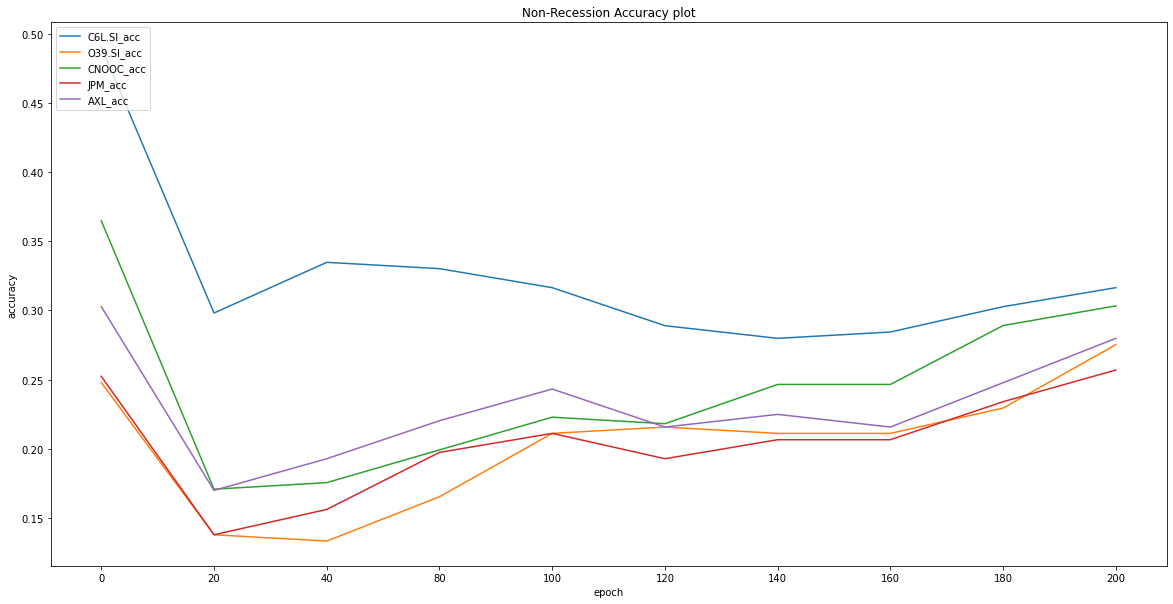

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

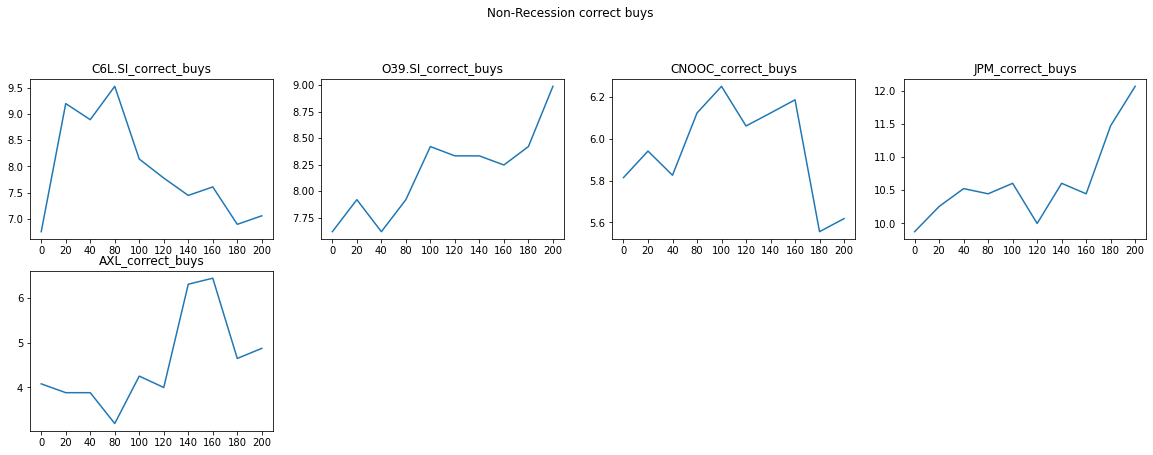

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

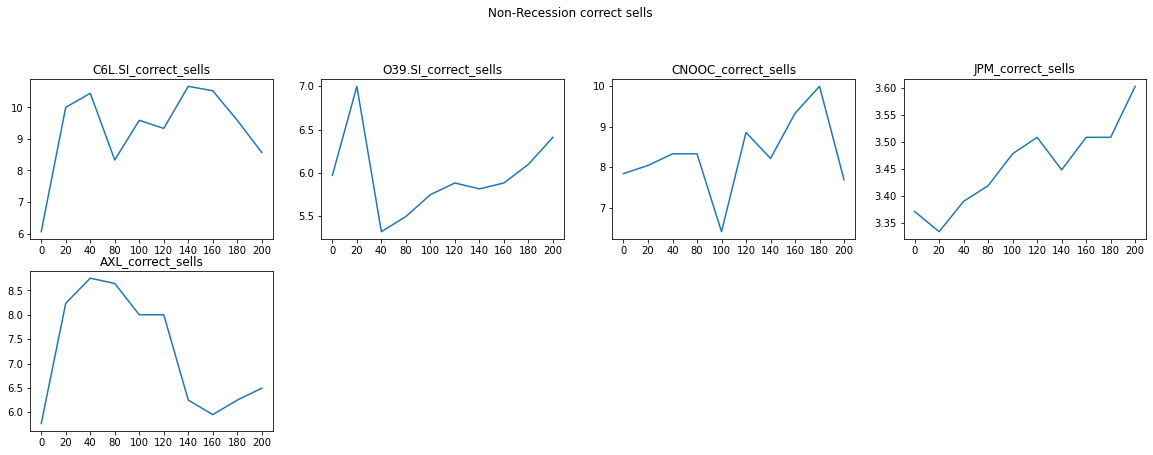

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

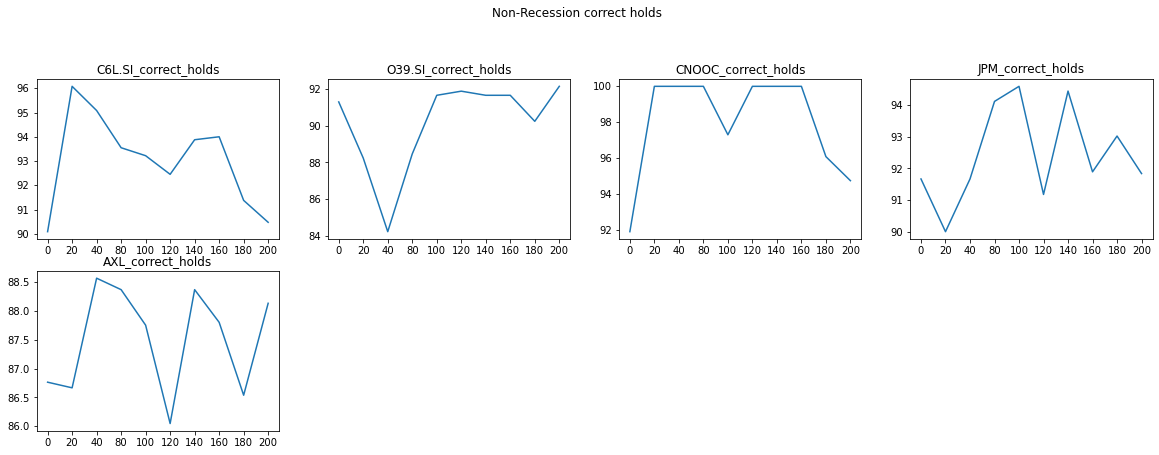

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

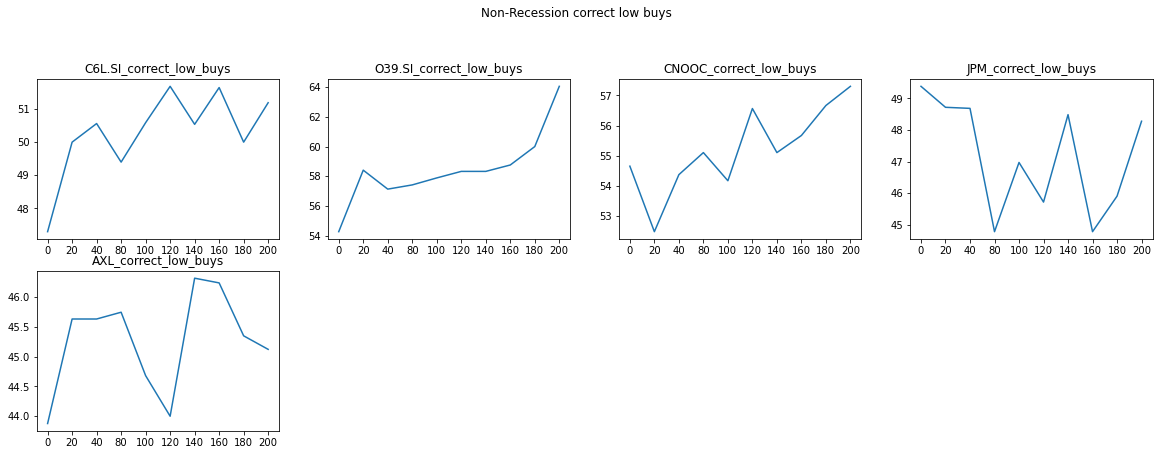

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

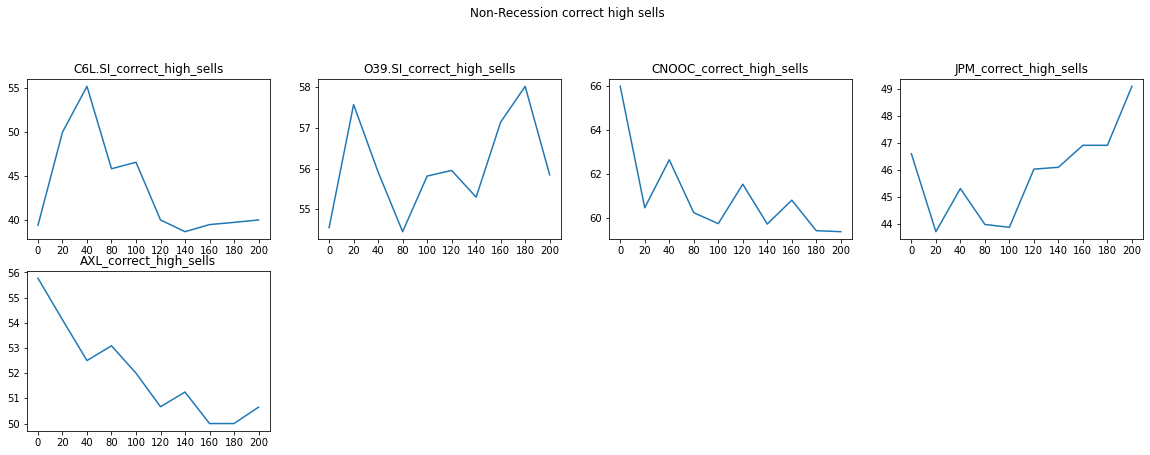

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

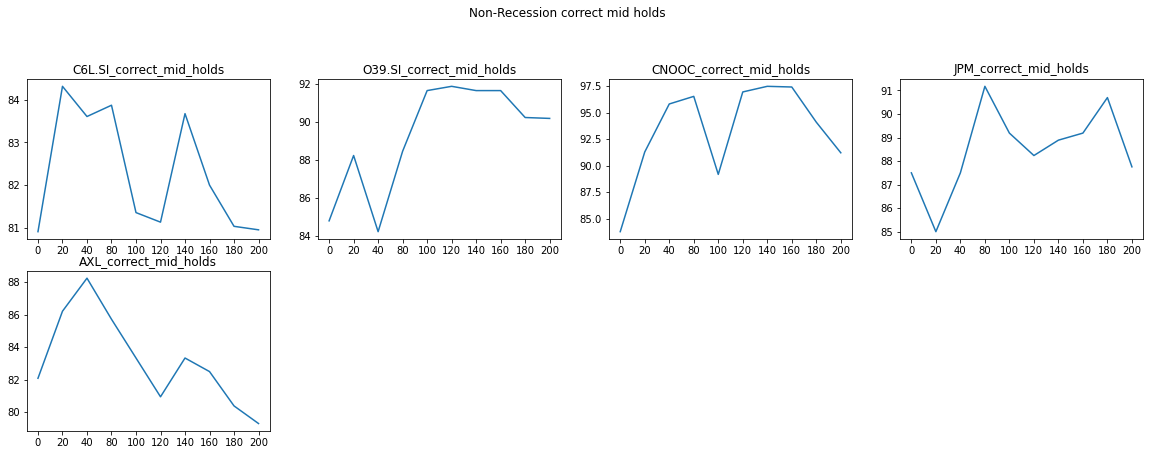

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

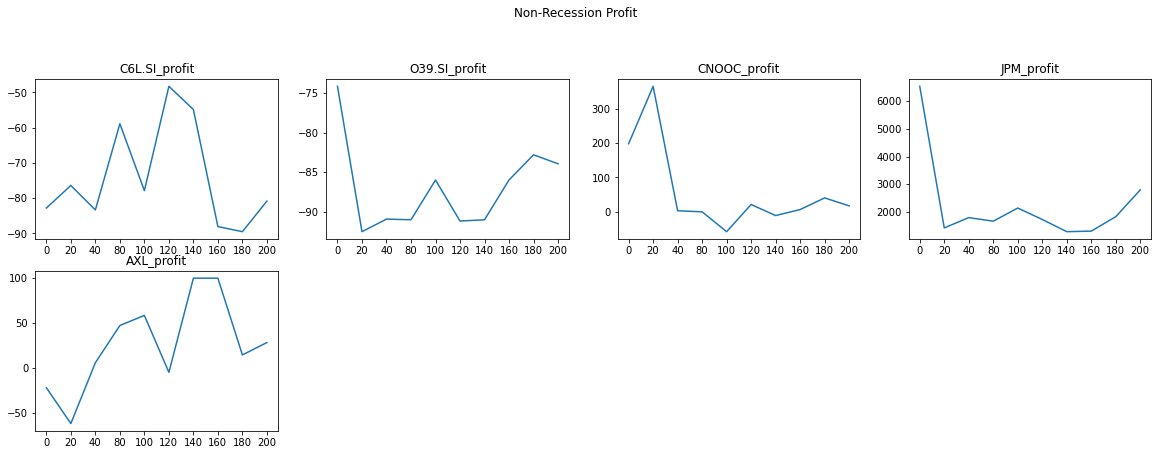

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [30]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


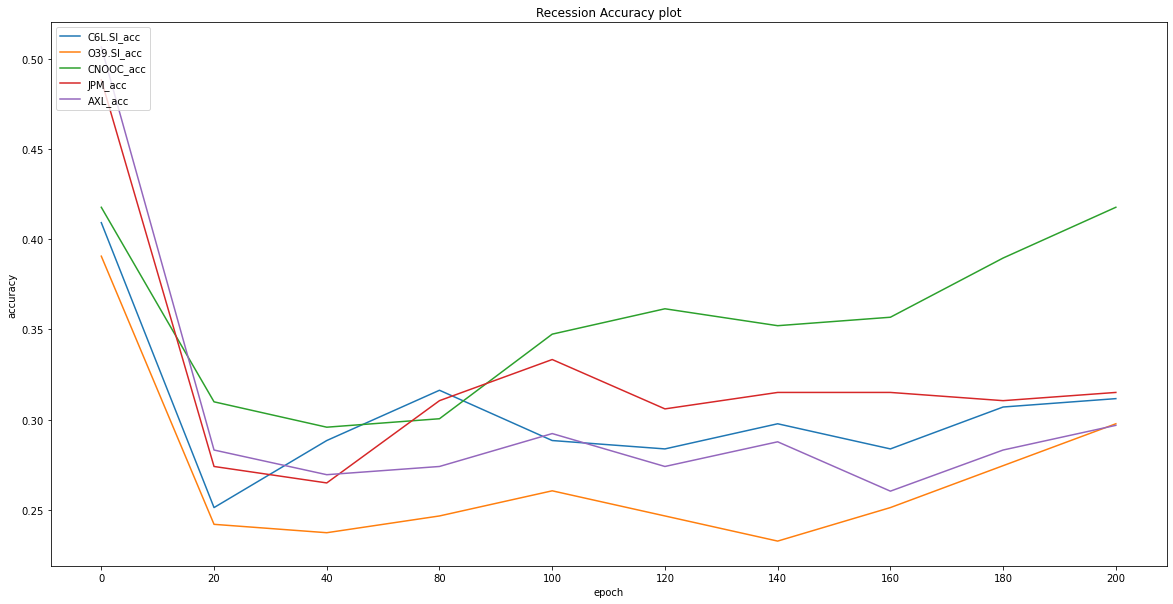

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

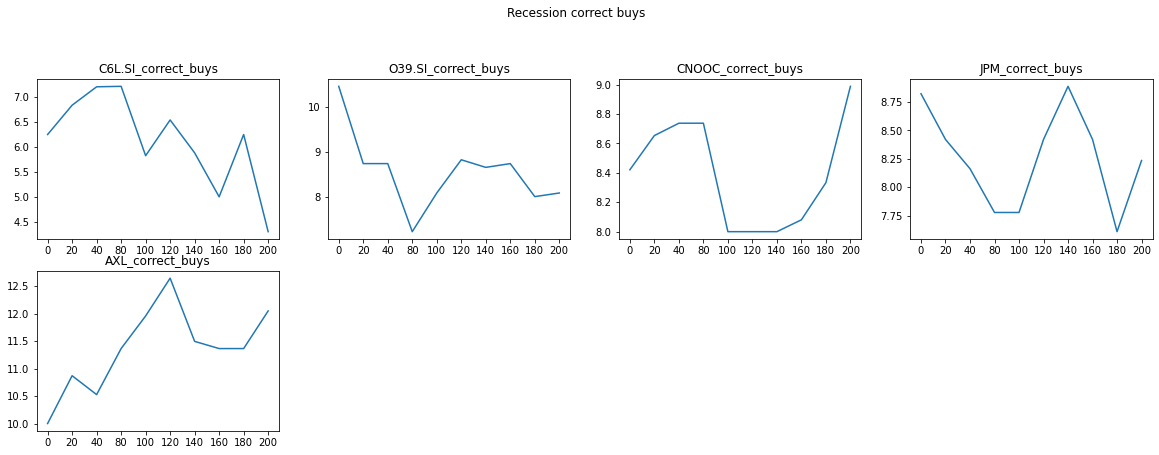

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

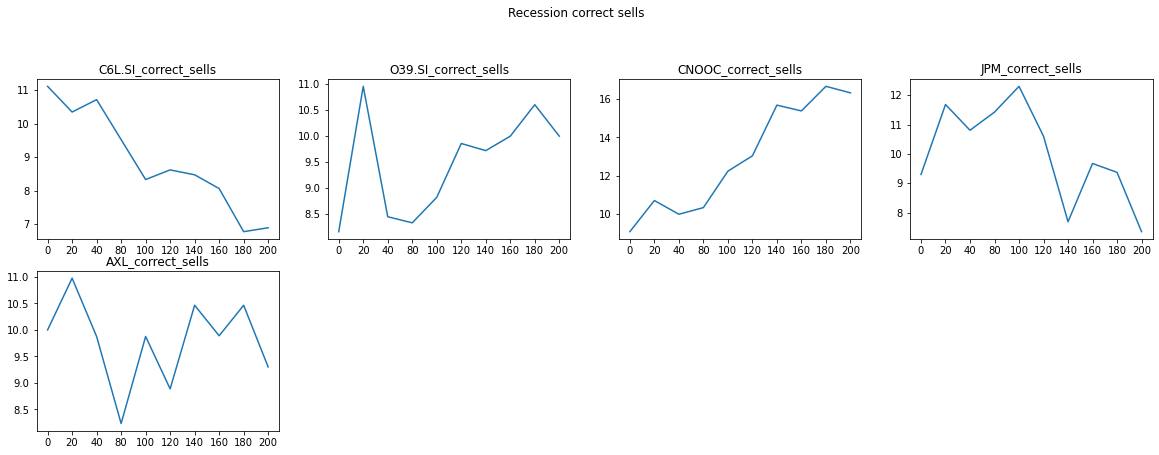

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

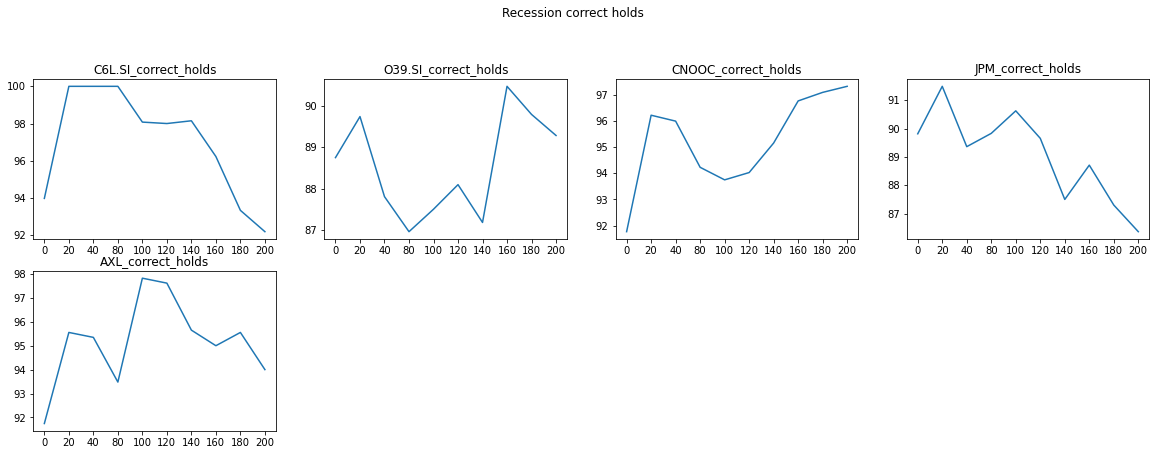

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

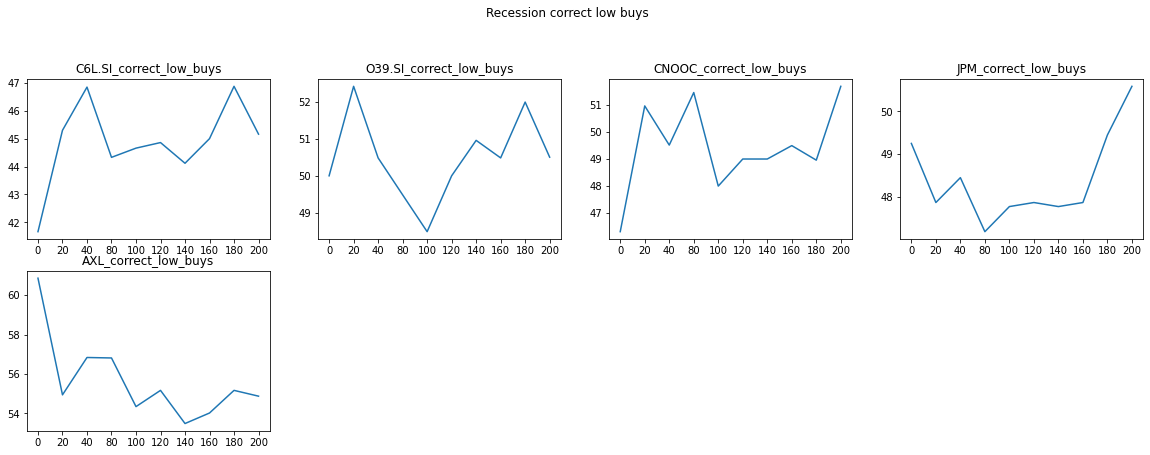

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

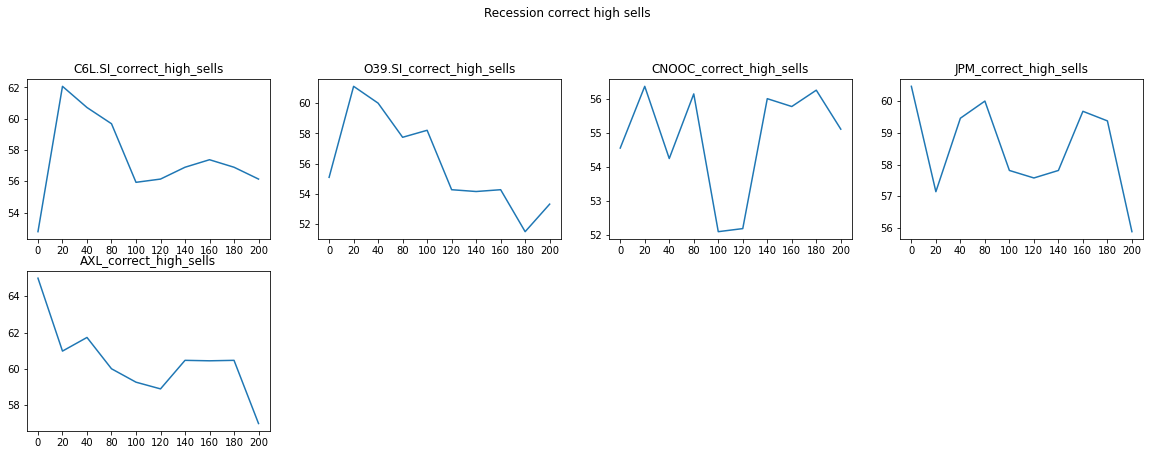

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

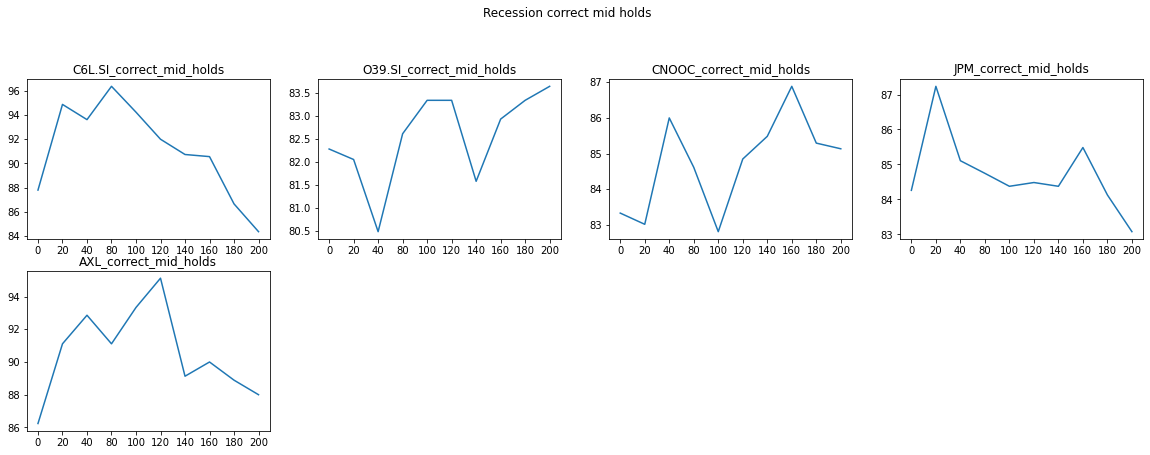

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

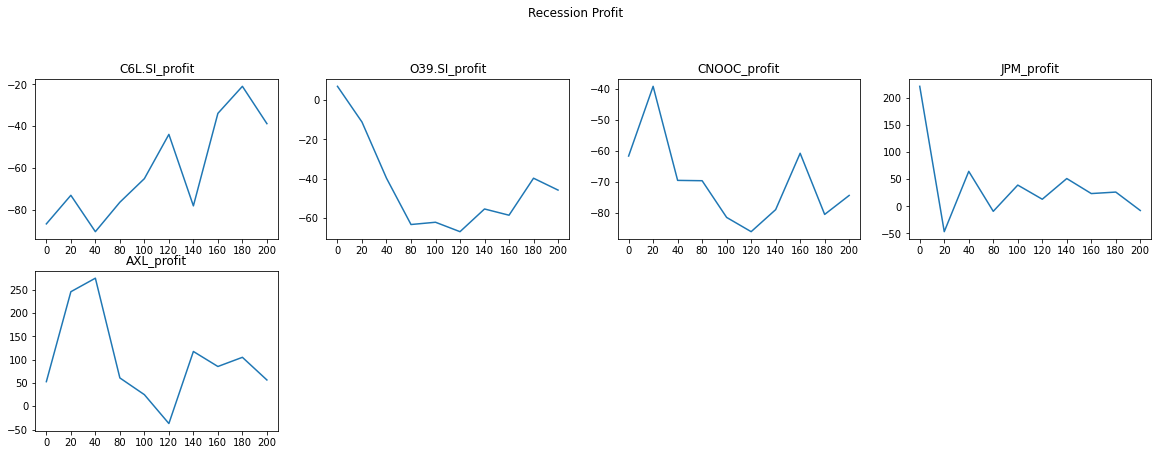

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")